## Upload data under data/ and hts_utils.py under utils/

This notebook was heavily modified from here:

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/NonNegativeReconciliation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%capture
# !pip install hierarchicalforecast statsforecast

In [2]:
import numpy as np
import pandas as pd

from utils.hts_eda_utils import *

from hierarchicalforecast.utils import HierarchicalPlot
from statsforecast.models import * # ARIMA, ETS, etc.
from statsforecast.core import StatsForecast

# TODO TopDown() reconciler causes KeyError 'ETS, Naive'. Same with Empirical Risk Minimization. Why?
from hierarchicalforecast.methods import * # Reconcialiation methods: BottomUp, TopDown, MinTrace etc.
from hierarchicalforecast.core import HierarchicalReconciliation

from hierarchicalforecast.evaluation import HierarchicalEvaluation

/Users/ariellubonja/anaconda3/envs/hierarchicalforecast/lib/python3.8/site-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# dataset subset to use? # Use full initially
#     deal_w_zeros_method = remove_zero_columns(df, any_or_all='any')

SELECT_TOP_K_PRODUCTS = None # None = keep all


# CHOOSE TIME SERIES METHODS HERE! https://nixtla.github.io/statsforecast/src/core/models_intro.html
TSModels = [
    ETS(season_length=7, model='ZAA'),
    Naive(),
    AutoETS(season_length=7, model='ZAA'), # I think this is newer version of ETS()
    ARIMA(),
    SeasonalExponentialSmoothingOptimized(season_length=7),
    AutoRegressive(lags=6),
    RandomWalkWithDrift()
    ]

# https://nixtla.github.io/hierarchicalforecast/methods.html
reconciliation_methods = [
    BottomUp(),
    TopDown(method='forecast_proportions'), # 'average_proportions' causes KeyError below
    MinTrace(method='wls_struct'), # Ols seems to not converge (SVD error)
    OptimalCombination(method='wls_struct'), # Same
    # ERM(method='closed') # Empirical Risk Minimization - KeyError
]

TIME_SERIES_FREQ = 'M'
df = pd.read_excel('data/Quarterly_smoothing.xlsx', index_col=0)#.iloc[:,:5])

/Users/ariellubonja/anaconda3/envs/hierarchicalforecast/lib/python3.8/site-packages/statsforecast/models.py:732: FutureWarning: `ETS` will be deprecated in future versions of `StatsForecast`. Please use `AutoETS` instead.
  ETS._warn()


In [4]:
dataset_hierarchy_delimiter = ' - ' # The delimiter currently used in the dataset
HIERARCHY_DELIMITER = '_' # '_' is needed by HierarchicalForecast. Need to replace

## 1. Load Data

In [5]:
df.columns = df.columns.str.replace(' - ', HIERARCHY_DELIMITER) # Replace Hierarchy delimiter

##### Columns of all zeros cause errors (Division by zero in Covariance calc.). Need to fix

In [6]:
# TODO make this transform a parameter too
df = add_1_to_all_df_cells(df)

df.columns[20:50]

Index(['Дальневосточный ФО_AMBROBENE_Ambrobene tabs 30 mg #20',
       'Дальневосточный ФО_AMBROBENE_Stoptussin tabs 4 mg + 100 mg #20',
       'Дальневосточный ФО_AMLODIPINE-TEVA_Amlodipine-Teva tabs 10 mg #30',
       'Дальневосточный ФО_AMLODIPINE-TEVA_Amlodipine-Teva tabs 5 mg #30',
       'Дальневосточный ФО_ANASTROSOLE_Anastrozole-Teva FC tabs 1 mg #28',
       'Дальневосточный ФО_ATORVASTATIN-TEVA_Atorvastatin-Teva FC tabs 10 mg #30',
       'Дальневосточный ФО_ATORVASTATIN-TEVA_Atorvastatin-Teva FC tabs 20 mg #30',
       'Дальневосточный ФО_ATORVASTATIN-TEVA_Atorvastatin-Teva FC tabs 40 mg #30',
       'Дальневосточный ФО_AZILECT_Azilect tabs 1 mg #100',
       'Дальневосточный ФО_AZILECT_Azilect tabs 1 mg #30',
       'Дальневосточный ФО_BECLASONE ECO_Beclazone Eco aerosol for inh 100 mcg 200 doses #1',
       'Дальневосточный ФО_BECLASONE ECO_Beclazone Eco aerosol for inh 250 mcg 200 doses #1',
       'Дальневосточный ФО_BECLASONE ECO_Beclazone Eco aerosol for inh 50 mcg 200

##### Optional: Select only top Products

Saves compute

In [7]:
# if SELECT_TOP_K_PRODUCTS is not None:
#     df = select_top_n_brands(df, n=SELECT_TOP_K_PRODUCTS)

# # df.head(5)
brand_name = 'BISOPROLOL-TEVA'
df_brand = select_brand(df, brand_name, HIERARCHY_DELIMITER='_')
df_brand.columns = [c.replace(brand_name + HIERARCHY_DELIMITER, "") for c in df_brand.columns]
df_brand.columns = ["_".join(c.split(HIERARCHY_DELIMITER)[::-1]) for c in df_brand.columns]
df_brand.columns

Index(['Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО',
       'Bisoprolol-Teva FC tabs 10 mg #50_Дальневосточный ФО',
       'Bisoprolol-Teva FC tabs 5 mg #30_Дальневосточный ФО',
       'Bisoprolol-Teva FC tabs 5 mg #50_Дальневосточный ФО',
       'Bisoprolol-Teva FC tabs 10 mg #30_Приволжский ФО',
       'Bisoprolol-Teva FC tabs 10 mg #50_Приволжский ФО',
       'Bisoprolol-Teva FC tabs 5 mg #30_Приволжский ФО',
       'Bisoprolol-Teva FC tabs 5 mg #50_Приволжский ФО',
       'Bisoprolol-Teva FC tabs 10 mg #30_Северо-западный ФО',
       'Bisoprolol-Teva FC tabs 10 mg #50_Северо-западный ФО',
       'Bisoprolol-Teva FC tabs 5 mg #30_Северо-западный ФО',
       'Bisoprolol-Teva FC tabs 5 mg #50_Северо-западный ФО',
       'Bisoprolol-Teva FC tabs 10 mg #30_Северо-кавказский ФО',
       'Bisoprolol-Teva FC tabs 10 mg #50_Северо-кавказский ФО',
       'Bisoprolol-Teva FC tabs 5 mg #30_Северо-кавказский ФО',
       'Bisoprolol-Teva FC tabs 5 mg #50_Северо-кавказский ФО',
       '

In [8]:
df_brand

,Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,Bisoprolol-Teva FC tabs 10 mg #50_Дальневосточный ФО,Bisoprolol-Teva FC tabs 5 mg #30_Дальневосточный ФО,Bisoprolol-Teva FC tabs 5 mg #50_Дальневосточный ФО,Bisoprolol-Teva FC tabs 10 mg #30_Приволжский ФО,Bisoprolol-Teva FC tabs 10 mg #50_Приволжский ФО,Bisoprolol-Teva FC tabs 5 mg #30_Приволжский ФО,Bisoprolol-Teva FC tabs 5 mg #50_Приволжский ФО,Bisoprolol-Teva FC tabs 10 mg #30_Северо-западный ФО,Bisoprolol-Teva FC tabs 10 mg #50_Северо-западный ФО,...,Bisoprolol-Teva FC tabs 5 mg #30_Уральский ФО,Bisoprolol-Teva FC tabs 5 mg #50_Уральский ФО,Bisoprolol-Teva FC tabs 10 mg #30_Центральный ФО,Bisoprolol-Teva FC tabs 10 mg #50_Центральный ФО,Bisoprolol-Teva FC tabs 5 mg #30_Центральный ФО,Bisoprolol-Teva FC tabs 5 mg #50_Центральный ФО,Bisoprolol-Teva FC tabs 10 mg #30_Южный ФО,Bisoprolol-Teva FC tabs 10 mg #50_Южный ФО,Bisoprolol-Teva FC tabs 5 mg #30_Южный ФО,Bisoprolol-Teva FC tabs 5 mg #50_Южный ФО
Month,,,,,,,,,,,,,,,,,,,,,
2018-03-01,4475,170,8920,611,39810,983,74980,1066,13483,523,...,39333,677,26757,168,13903,769,10272,181,11379,69
2018-04-01,7394,273,19969,707,67274,1027,119736,1474,14813,1454,...,43712,725,53317,639,66399,3856,17122,407,20741,993
2018-05-01,8836,1063,26304,1307,67153,1145,117562,2954,10093,1636,...,60264,1614,65601,2254,103821,7359,19740,629,33587,1455
2018-06-01,20156,1958,36987,3477,43315,1125,58628,4257,13125,1393,...,45874,1858,77633,3354,484082,7346,32751,1265,39578,2711
2018-07-01,17290,2535,26707,4806,19195,1457,21094,4126,12175,497,...,70248,2192,83843,3334,459791,4732,29467,1406,63421,1859
2018-08-01,20649,1745,24489,4508,53201,1487,123196,4588,12018,333,...,99915,1604,60404,1783,426612,1893,28649,1314,50877,1563
2018-09-01,7772,681,13567,2020,80486,1694,178477,2904,7892,354,...,76702,1444,59757,1598,43716,2118,9021,578,40711,787
2018-10-01,13244,271,21275,845,91392,1484,190313,5881,12832,439,...,98857,6167,39614,1353,30651,1917,27981,901,177315,735
2018-11-01,9290,277,19030,645,76317,792,115860,4583,15564,521,...,89657,5848,48800,2667,57036,3234,27510,805,179778,973


In [9]:
%%capture
df_with_aggregates, hierarchy = prep_data_for_scikit_hts_prod_region(df_brand)

In [10]:
df_with_aggregates

,Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,Bisoprolol-Teva FC tabs 10 mg #50_Дальневосточный ФО,Bisoprolol-Teva FC tabs 5 mg #30_Дальневосточный ФО,Bisoprolol-Teva FC tabs 5 mg #50_Дальневосточный ФО,Bisoprolol-Teva FC tabs 10 mg #30_Приволжский ФО,Bisoprolol-Teva FC tabs 10 mg #50_Приволжский ФО,Bisoprolol-Teva FC tabs 5 mg #30_Приволжский ФО,Bisoprolol-Teva FC tabs 5 mg #50_Приволжский ФО,Bisoprolol-Teva FC tabs 10 mg #30_Северо-западный ФО,Bisoprolol-Teva FC tabs 10 mg #50_Северо-западный ФО,...,Bisoprolol-Teva FC tabs 5 mg #50_Центральный ФО,Bisoprolol-Teva FC tabs 10 mg #30_Южный ФО,Bisoprolol-Teva FC tabs 10 mg #50_Южный ФО,Bisoprolol-Teva FC tabs 5 mg #30_Южный ФО,Bisoprolol-Teva FC tabs 5 mg #50_Южный ФО,Bisoprolol-Teva FC tabs 5 mg #30,Bisoprolol-Teva FC tabs 5 mg #50,Bisoprolol-Teva FC tabs 10 mg #30,Bisoprolol-Teva FC tabs 10 mg #50,Total
Month,,,,,,,,,,,,,,,,,,,,,
2018-03-01,4475,170,8920,611,39810,983,74980,1066,13483,523,...,769,10272,181,11379,69,204641,6713,146480,3293,722254
2018-04-01,7394,273,19969,707,67274,1027,119736,1474,14813,1454,...,3856,17122,407,20741,993,366968,13725,241009,6296,1255996
2018-05-01,8836,1063,26304,1307,67153,1145,117562,2954,10093,1636,...,7359,19740,629,33587,1455,485199,24380,260685,10623,1561774
2018-06-01,20156,1958,36987,3477,43315,1125,58628,4257,13125,1393,...,7346,32751,1265,39578,2711,807629,29466,270577,12296,2239936
2018-07-01,17290,2535,26707,4806,19195,1457,21094,4126,12175,497,...,4732,29467,1406,63421,1859,756040,27448,260287,13116,2113782
2018-08-01,20649,1745,24489,4508,53201,1487,123196,4588,12018,333,...,1893,28649,1314,50877,1563,883745,19383,309475,9230,2443666
2018-09-01,7772,681,13567,2020,80486,1694,178477,2904,7892,354,...,2118,9021,578,40711,787,499672,13234,263570,8857,1570666
2018-10-01,13244,271,21275,845,91392,1484,190313,5881,12832,439,...,1917,27981,901,177315,735,784626,19715,321531,7367,2266478
2018-11-01,9290,277,19030,645,76317,792,115860,4583,15564,521,...,3234,27510,805,179778,973,677462,24997,310227,16975,2059322


In [11]:
df_with_aggregates.shape

(57, 37)

In [12]:
hierarchy

{'Total': ['Bisoprolol-Teva FC tabs 5 mg #30',
  'Bisoprolol-Teva FC tabs 5 mg #50',
  'Bisoprolol-Teva FC tabs 10 mg #30',
  'Bisoprolol-Teva FC tabs 10 mg #50'],
 'Bisoprolol-Teva FC tabs 5 mg #30': ['Bisoprolol-Teva FC tabs 5 mg #30_Дальневосточный ФО',
  'Bisoprolol-Teva FC tabs 5 mg #30_Южный ФО',
  'Bisoprolol-Teva FC tabs 5 mg #30_Приволжский ФО',
  'Bisoprolol-Teva FC tabs 5 mg #30_Северо-западный ФО',
  'Bisoprolol-Teva FC tabs 5 mg #30_Сибирский ФО',
  'Bisoprolol-Teva FC tabs 5 mg #30_Северо-кавказский ФО',
  'Bisoprolol-Teva FC tabs 5 mg #30_Уральский ФО',
  'Bisoprolol-Teva FC tabs 5 mg #30_Центральный ФО'],
 'Bisoprolol-Teva FC tabs 5 mg #50': ['Bisoprolol-Teva FC tabs 5 mg #50_Дальневосточный ФО',
  'Bisoprolol-Teva FC tabs 5 mg #50_Южный ФО',
  'Bisoprolol-Teva FC tabs 5 mg #50_Приволжский ФО',
  'Bisoprolol-Teva FC tabs 5 mg #50_Северо-западный ФО',
  'Bisoprolol-Teva FC tabs 5 mg #50_Сибирский ФО',
  'Bisoprolol-Teva FC tabs 5 mg #50_Северо-кавказский ФО',
  'Bisoprol

<font color='cyan'>HierarchicalForecast likes data to be Drug | Date | Sales, rather than having DrugName as columns</font>


### Melt data into format required by HierarchicalForecast

Following how their example code's data looks

In [13]:
# Melt the DataFrame - convert ColNames to rows to match input to HierForecast
df_with_aggregates.reset_index(inplace=True) # Move Month index to column (package requirement)

# TODO Check these for prediction error
melted_df = df_with_aggregates.melt(id_vars=['Month'], var_name='Drug', value_name='Sales')

# Convert melted DataFrame to the required format
melted_df = melted_df[['Drug', 'Month', 'Sales']]

# Col names seem to need to be thus for package
melted_df.rename(columns={'Drug': 'unique_id', 'Month':'ds', 'Sales':'y'}, inplace=True)


print(melted_df.head())
print(melted_df.tail())


                                           unique_id         ds      y
0  Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ... 2018-03-01   4475
1  Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ... 2018-04-01   7394
2  Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ... 2018-05-01   8836
3  Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ... 2018-06-01  20156
4  Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ... 2018-07-01  17290
     unique_id         ds        y
2104     Total 2022-07-01  3102086
2105     Total 2022-08-01  4226404
2106     Total 2022-09-01  4372050
2107     Total 2022-10-01  3895336
2108     Total 2022-11-01  3644116


### Creating `S_df`

All colored font is Ariel

<font color='turquoise'>We've created `Y_df, tags`. All we need is `S_df`</font>
This is like a tree representing the hierarchy, with aggregations at each level

<font color='blue'>`S_df` is a representation of the Hierarchy - 1 means that column name (item, Drugs in our case), belongs to the Total row. Rows represent totals at each level of the hierarchy, for each node</font>

In [14]:
S_df = create_S_df(df_brand)

S_df

,Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,Bisoprolol-Teva FC tabs 10 mg #50_Дальневосточный ФО,Bisoprolol-Teva FC tabs 5 mg #30_Дальневосточный ФО,Bisoprolol-Teva FC tabs 5 mg #50_Дальневосточный ФО,Bisoprolol-Teva FC tabs 10 mg #30_Приволжский ФО,Bisoprolol-Teva FC tabs 10 mg #50_Приволжский ФО,Bisoprolol-Teva FC tabs 5 mg #30_Приволжский ФО,Bisoprolol-Teva FC tabs 5 mg #50_Приволжский ФО,Bisoprolol-Teva FC tabs 10 mg #30_Северо-западный ФО,Bisoprolol-Teva FC tabs 10 mg #50_Северо-западный ФО,...,Bisoprolol-Teva FC tabs 5 mg #30_Уральский ФО,Bisoprolol-Teva FC tabs 5 mg #50_Уральский ФО,Bisoprolol-Teva FC tabs 10 mg #30_Центральный ФО,Bisoprolol-Teva FC tabs 10 mg #50_Центральный ФО,Bisoprolol-Teva FC tabs 5 mg #30_Центральный ФО,Bisoprolol-Teva FC tabs 5 mg #50_Центральный ФО,Bisoprolol-Teva FC tabs 10 mg #30_Южный ФО,Bisoprolol-Teva FC tabs 10 mg #50_Южный ФО,Bisoprolol-Teva FC tabs 5 mg #30_Южный ФО,Bisoprolol-Teva FC tabs 5 mg #50_Южный ФО
Total,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Bisoprolol-Teva FC tabs 10 mg #30,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bisoprolol-Teva FC tabs 10 mg #30_Приволжский ФО,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bisoprolol-Teva FC tabs 10 mg #30_Северо-западный ФО,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Bisoprolol-Teva FC tabs 10 mg #30_Северо-кавказский ФО,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bisoprolol-Teva FC tabs 10 mg #30_Сибирский ФО,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bisoprolol-Teva FC tabs 10 mg #30_Уральский ФО,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bisoprolol-Teva FC tabs 10 mg #30_Центральный ФО,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Bisoprolol-Teva FC tabs 10 mg #30_Южный ФО,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [15]:
S_df.shape

(37, 32)

### Create `tags`, which is a description of the Hierarchy as `dict`

Original `tags` loaded from example Dataset - they didn't create it programmatically

In [16]:
# TODO wtf did chatgpt do here?
transformed_data = { # Need names for hierarchy levels IMO
    "Molecule": ["Total"],
    "Molecule/Product": hierarchy['Total'],
    "Molecule/Product/Region": sum([hierarchy[region] for region in hierarchy['Total']], []),
    #"Sales/Region/DrugName/DrugDosage": sum([hierarchy[key] for key in sum([hierarchy[region] for region in hierarchy['Total']], [])], []),
}

# Convert the lists to numpy arrays for consistency with the format
for key in transformed_data:
    transformed_data[key] = np.array(transformed_data[key], dtype=object)

# print(transformed_data)
tags = transformed_data

In [17]:
tags

{'Molecule': array(['Total'], dtype=object),
 'Molecule/Product': array(['Bisoprolol-Teva FC tabs 5 mg #30',
        'Bisoprolol-Teva FC tabs 5 mg #50',
        'Bisoprolol-Teva FC tabs 10 mg #30',
        'Bisoprolol-Teva FC tabs 10 mg #50'], dtype=object),
 'Molecule/Product/Region': array(['Bisoprolol-Teva FC tabs 5 mg #30_Дальневосточный ФО',
        'Bisoprolol-Teva FC tabs 5 mg #30_Южный ФО',
        'Bisoprolol-Teva FC tabs 5 mg #30_Приволжский ФО',
        'Bisoprolol-Teva FC tabs 5 mg #30_Северо-западный ФО',
        'Bisoprolol-Teva FC tabs 5 mg #30_Сибирский ФО',
        'Bisoprolol-Teva FC tabs 5 mg #30_Северо-кавказский ФО',
        'Bisoprolol-Teva FC tabs 5 mg #30_Уральский ФО',
        'Bisoprolol-Teva FC tabs 5 mg #30_Центральный ФО',
        'Bisoprolol-Teva FC tabs 5 mg #50_Дальневосточный ФО',
        'Bisoprolol-Teva FC tabs 5 mg #50_Южный ФО',
        'Bisoprolol-Teva FC tabs 5 mg #50_Приволжский ФО',
        'Bisoprolol-Teva FC tabs 5 mg #50_Северо-западный ФО',


We split the dataframe in train/test splits.

In [18]:
Y_df = melted_df

Y_df

,unique_id,ds,y
0,Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ...,2018-03-01,4475
1,Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ...,2018-04-01,7394
2,Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ...,2018-05-01,8836
3,Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ...,2018-06-01,20156
4,Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ...,2018-07-01,17290
...,...,...,...
2104,Total,2022-07-01,3102086
2105,Total,2022-08-01,4226404
2106,Total,2022-09-01,4372050
2107,Total,2022-10-01,3895336


In [19]:
Y_test_df = Y_df.groupby('unique_id').tail(10) # Original code
Y_train_df = Y_df.drop(Y_test_df.index)

Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

In [20]:
print(Y_test_df.head())
print(Y_test_df.tail())

                                                           ds      y
unique_id                                                           
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточн... 2022-02-01  17466
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточн... 2022-03-01  21130
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточн... 2022-04-01  20656
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточн... 2022-05-01  20823
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточн... 2022-06-01  25081
                  ds        y
unique_id                    
Total     2022-07-01  3102086
Total     2022-08-01  4226404
Total     2022-09-01  4372050
Total     2022-10-01  3895336
Total     2022-11-01  3644116


## 2. Base Forecasts

The following cell computes the *base forecast* for each time series using the `ETS` and `naive` models. Observe that `Y_hat_df` contains the forecasts but they are not coherent.

In [21]:
%%capture
fcst = StatsForecast(
    df=Y_train_df,
    models=TSModels,
    # models=[ETS(season_length=7, model='ZZA'), Naive()],
    freq=TIME_SERIES_FREQ,
    n_jobs=-1
)
Y_hat_df = fcst.forecast(h=10, fitted = True) # TODO What is h=7?
Y_fitted_df = fcst.forecast_fitted_values()

In [22]:
Y_fitted_df

,ds,y,ETS,Naive,AutoETS,ARIMA,SeasESOpt,AutoRegressive,RWD
unique_id,,,,,,,,,
Bisoprolol-Teva FC tabs 10 mg #30,2018-03-01,146480.0,1.441883e+05,NaN,1.441883e+05,4.674462e+05,NaN,3.156677e+05,NaN
Bisoprolol-Teva FC tabs 10 mg #30,2018-04-01,241009.0,1.893092e+05,146480.0,1.893092e+05,4.674462e+05,NaN,2.248769e+05,1.534954e+05
Bisoprolol-Teva FC tabs 10 mg #30,2018-05-01,260685.0,3.211245e+05,241009.0,3.211245e+05,4.674462e+05,NaN,3.061254e+05,2.480244e+05
Bisoprolol-Teva FC tabs 10 mg #30,2018-06-01,270577.0,3.077253e+05,260685.0,3.077253e+05,4.674462e+05,NaN,3.319350e+05,2.677004e+05
Bisoprolol-Teva FC tabs 10 mg #30,2018-07-01,260287.0,2.931906e+05,270577.0,2.931906e+05,4.674462e+05,NaN,2.532193e+05,2.775924e+05
...,...,...,...,...,...,...,...,...,...
Total,2021-09-01,3109588.0,1.437279e+06,1470772.0,1.437279e+06,3.209535e+06,2810029.5,2.090496e+06,1.542184e+06
Total,2021-10-01,4012742.0,3.084791e+06,3109588.0,3.084791e+06,3.209535e+06,2665331.0,4.291136e+06,3.181000e+06
Total,2021-11-01,5621248.0,4.522825e+06,4012742.0,4.522825e+06,3.209535e+06,3223033.0,4.157858e+06,4.084154e+06


In [23]:
Y_hat_df

,ds,ETS,Naive,AutoETS,ARIMA,SeasESOpt,AutoRegressive,RWD
unique_id,,,,,,,,
Bisoprolol-Teva FC tabs 10 mg #30,2022-01-31,4.878302e+05,469190.0,4.878302e+05,4.674462e+05,3.494135e+05,3.978005e+05,4.762054e+05
Bisoprolol-Teva FC tabs 10 mg #30,2022-02-28,4.496908e+05,469190.0,4.496908e+05,4.674462e+05,4.009917e+05,4.374121e+05,4.832209e+05
Bisoprolol-Teva FC tabs 10 mg #30,2022-03-31,5.005894e+05,469190.0,5.005894e+05,4.674462e+05,5.210110e+05,4.752149e+05,4.902363e+05
Bisoprolol-Teva FC tabs 10 mg #30,2022-04-30,5.439860e+05,469190.0,5.439860e+05,4.674462e+05,5.397759e+05,5.127333e+05,4.972518e+05
Bisoprolol-Teva FC tabs 10 mg #30,2022-05-31,6.287009e+05,469190.0,6.287009e+05,4.674462e+05,4.972445e+05,4.841960e+05,5.042672e+05
...,...,...,...,...,...,...,...,...
Total,2022-06-30,4.117565e+06,4007200.0,4.117565e+06,3.209535e+06,3.305472e+06,3.301046e+06,4.435671e+06
Total,2022-07-31,4.409718e+06,4007200.0,4.409718e+06,3.209535e+06,1.491639e+06,2.749932e+06,4.507083e+06
Total,2022-08-31,4.281864e+06,4007200.0,4.281864e+06,3.209535e+06,3.106592e+06,3.055143e+06,4.578495e+06


Observe that the ETS model computes negative forecasts for some series.

<font color='pink'>Does `Y_hat_df` have a `ds` column in the original code?</font>

Yes

In [24]:
#Y_hat_df['ds'] = Y_test_df['ds'] ## the model doesn't compute the dates well
Y_hat_df
#Y_test_df

,ds,ETS,Naive,AutoETS,ARIMA,SeasESOpt,AutoRegressive,RWD
unique_id,,,,,,,,
Bisoprolol-Teva FC tabs 10 mg #30,2022-01-31,4.878302e+05,469190.0,4.878302e+05,4.674462e+05,3.494135e+05,3.978005e+05,4.762054e+05
Bisoprolol-Teva FC tabs 10 mg #30,2022-02-28,4.496908e+05,469190.0,4.496908e+05,4.674462e+05,4.009917e+05,4.374121e+05,4.832209e+05
Bisoprolol-Teva FC tabs 10 mg #30,2022-03-31,5.005894e+05,469190.0,5.005894e+05,4.674462e+05,5.210110e+05,4.752149e+05,4.902363e+05
Bisoprolol-Teva FC tabs 10 mg #30,2022-04-30,5.439860e+05,469190.0,5.439860e+05,4.674462e+05,5.397759e+05,5.127333e+05,4.972518e+05
Bisoprolol-Teva FC tabs 10 mg #30,2022-05-31,6.287009e+05,469190.0,6.287009e+05,4.674462e+05,4.972445e+05,4.841960e+05,5.042672e+05
...,...,...,...,...,...,...,...,...
Total,2022-06-30,4.117565e+06,4007200.0,4.117565e+06,3.209535e+06,3.305472e+06,3.301046e+06,4.435671e+06
Total,2022-07-31,4.409718e+06,4007200.0,4.409718e+06,3.209535e+06,1.491639e+06,2.749932e+06,4.507083e+06
Total,2022-08-31,4.281864e+06,4007200.0,4.281864e+06,3.209535e+06,3.106592e+06,3.055143e+06,4.578495e+06


In [25]:
Y_test_df

,ds,y
unique_id,,
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-02-01,17466
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-03-01,21130
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-04-01,20656
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-05-01,20823
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-06-01,25081
...,...,...
Total,2022-07-01,3102086
Total,2022-08-01,4226404
Total,2022-09-01,4372050


In [26]:
# `S_df` should have 1 entry for each unique row in `Y_hat_df`
assert(len(S_df.index) == len(set(Y_hat_df.index)))
assert(set(Y_train_df.index) - set(S_df.index) == set())
assert(set(S_df.index) - set(Y_train_df.index) == set())

## 3. Non-Negative Reconciliation

The following cell makes the previous forecasts coherent and nonnegative using the `HierarchicalReconciliation` class.

In [27]:
hrec = HierarchicalReconciliation(reconcilers=reconciliation_methods)


Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df,
                          S=S_df, tags=tags)

Y_rec_df.head()

,ds,ETS,Naive,AutoETS,ARIMA,SeasESOpt,AutoRegressive,RWD,ETS/BottomUp,Naive/BottomUp,...,SeasESOpt/MinTrace_method-wls_struct,AutoRegressive/MinTrace_method-wls_struct,RWD/MinTrace_method-wls_struct,ETS/OptimalCombination_method-wls_struct,Naive/OptimalCombination_method-wls_struct,AutoETS/OptimalCombination_method-wls_struct,ARIMA/OptimalCombination_method-wls_struct,SeasESOpt/OptimalCombination_method-wls_struct,AutoRegressive/OptimalCombination_method-wls_struct,RWD/OptimalCombination_method-wls_struct
unique_id,,,,,,,,,,,,,,,,,,,,,
Total,2022-01-31,3890069.75,4007200.0,3890069.75,3209535.0,3106592.50,2826829.75,4078611.75,2049985.000,2003600.0,...,2.017541e+06,1.894159e+06,2.719075e+06,2.679160e+06,2.671467e+06,2.679160e+06,2.139690e+06,2.017541e+06,1.894159e+06,2.719075e+06
Total,2022-02-28,3371261.00,4007200.0,3371261.00,3209535.0,3678424.00,3354781.00,4150023.75,1992756.000,2003600.0,...,2.372650e+06,2.150034e+06,2.766682e+06,2.358044e+06,2.671467e+06,2.358044e+06,2.139690e+06,2.372650e+06,2.150034e+06,2.766682e+06
Total,2022-03-31,3346584.50,4007200.0,3346584.50,3209535.0,4531741.00,3776429.25,4221435.50,1978182.625,2003600.0,...,2.955632e+06,2.402035e+06,2.814290e+06,2.348451e+06,2.671467e+06,2.348451e+06,2.139690e+06,2.955632e+06,2.402035e+06,2.814290e+06
Total,2022-04-30,3340011.50,4007200.0,3340011.50,3209535.0,3983910.25,4398597.00,4292847.50,2018615.625,2003600.0,...,2.637124e+06,2.746776e+06,2.861898e+06,2.380859e+06,2.671467e+06,2.380859e+06,2.139690e+06,2.637124e+06,2.746776e+06,2.861898e+06
Total,2022-05-31,3859134.25,4007200.0,3859134.25,3209535.0,3861946.00,3841194.50,4364259.50,2390530.750,2003600.0,...,2.536270e+06,2.467457e+06,2.909506e+06,2.769503e+06,2.671467e+06,2.769503e+06,2.139690e+06,2.536270e+06,2.467457e+06,2.909506e+06


In [28]:
# assign correct time stamps, the package doesn't compute them correctly
Y_rec_df['ds'] = list(Y_test_df['ds'])
Y_hat_df['ds'] = list(Y_test_df['ds'])

## 4. Evaluation

The `HierarchicalForecast` package includes the `HierarchicalEvaluation` class to evaluate the different hierarchies and also is capable of compute scaled metrics compared to a benchmark model.

In [29]:
# TODO enhance this
def mse(y, y_hat):
    return np.mean((y-y_hat)**2)

evaluator = HierarchicalEvaluation(evaluators=[mean_absolute_percentage_error, symmetric_mean_absolute_percentage_error])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, Y_test_df=Y_test_df,Y_df=Y_train_df,
        tags=tags#, benchmark='Naive'
)
evaluation = evaluation.applymap('{:.2f}'.format)
evaluation = evaluation.reset_index()

In [30]:
evaluation['metric'] = evaluation['metric'].apply(lambda x: "".join([y[0] for y in x.split("_")]))

In [31]:
evaluation_ARIMA = evaluation[['level','metric']+[c for c in evaluation.columns if "ARIMA" in c]]
evaluation_ARIMA

,level,metric,ARIMA,ARIMA/BottomUp,ARIMA/TopDown_method-forecast_proportions,ARIMA/MinTrace_method-wls_struct,ARIMA/OptimalCombination_method-wls_struct
0,Overall,mape,863.55,864.47,1768.78,26878.04,26878.04
1,Overall,smape,731.21,745.76,929.23,1061.56,1061.56
2,Molecule,mape,18.88,52.86,18.88,37.15,37.15
3,Molecule,smape,193.42,731.59,193.42,473.15,473.15
4,Molecule/Product,mape,67.19,67.19,165.47,889.51,889.51
5,Molecule/Product,smape,518.49,518.49,732.29,779.46,779.46
6,Molecule/Product/Region,mape,989.49,989.49,2023.88,30965.38,30965.38
7,Molecule/Product/Region,smape,774.61,774.61,976.84,1115.21,1115.21


In [32]:
evaluation_ETS = evaluation[['level','metric']+[c for c in evaluation.columns if "ETS" in c]]
evaluation_ETS

,level,metric,ETS,AutoETS,ETS/BottomUp,AutoETS/BottomUp,ETS/TopDown_method-forecast_proportions,AutoETS/TopDown_method-forecast_proportions,ETS/MinTrace_method-wls_struct,AutoETS/MinTrace_method-wls_struct,ETS/OptimalCombination_method-wls_struct,AutoETS/OptimalCombination_method-wls_struct
0,Overall,mape,781.17,781.17,783.96,783.96,879.34,879.34,25308.28,25308.28,25308.28,25308.28
1,Overall,smape,883.88,883.88,890.43,890.43,1046.90,1046.90,1109.31,1109.31,1109.31,1109.31
2,Molecule,mape,17.69,17.69,32.27,32.27,17.69,17.69,24.84,24.84,24.84,24.84
3,Molecule,smape,151.73,151.73,396.72,396.72,151.73,151.73,286.99,286.99,286.99,286.99
4,Molecule/Product,mape,55.54,55.54,77.71,77.71,135.00,135.00,867.37,867.37,867.37,867.37
5,Molecule/Product,smape,564.52,564.52,563.91,563.91,779.02,779.02,866.50,866.50,866.50,866.50
6,Molecule/Product/Region,mape,895.73,895.73,895.73,895.73,999.31,999.31,29153.51,29153.51,29153.51,29153.51
7,Molecule/Product/Region,smape,946.67,946.67,946.67,946.67,1108.36,1108.36,1165.36,1165.36,1165.36,1165.36


In [33]:
evaluation_AutoRegressive = evaluation[['level','metric']+[c for c in evaluation.columns if "AutoRegressive" in c]]
evaluation_AutoRegressive

,level,metric,AutoRegressive,AutoRegressive/BottomUp,AutoRegressive/TopDown_method-forecast_proportions,AutoRegressive/MinTrace_method-wls_struct,AutoRegressive/OptimalCombination_method-wls_struct
0,Overall,mape,829.39,830.33,1734.82,30873.04,30873.04
1,Overall,smape,745.86,763.04,976.56,1094.16,1094.16
2,Molecule,mape,15.56,55.14,15.56,35.25,35.25
3,Molecule,smape,162.56,771.07,162.56,442.35,442.35
4,Molecule/Product,mape,64.72,63.53,169.95,1008.42,1008.42
5,Molecule/Product,smape,494.95,501.73,740.97,817.41,817.41
6,Molecule/Product/Region,mape,950.41,950.41,1984.16,35569.80,35569.80
7,Molecule/Product/Region,smape,795.45,795.45,1031.45,1149.12,1149.12


In [34]:
evaluation_SeasESOpt = evaluation[['level','metric']+[c for c in evaluation.columns if "SeasESOpt" in c]]
evaluation_SeasESOpt

,level,metric,SeasESOpt,SeasESOpt/BottomUp,SeasESOpt/TopDown_method-forecast_proportions,SeasESOpt/MinTrace_method-wls_struct,SeasESOpt/OptimalCombination_method-wls_struct
0,Overall,mape,397.62,397.14,843.94,33719.81,33719.81
1,Overall,smape,736.94,744.05,916.68,1086.61,1086.61
2,Molecule,mape,25.01,51.35,25.01,32.41,32.41
3,Molecule,smape,267.29,706.96,267.29,420.89,420.89
4,Molecule/Product,mape,65.87,54.87,148.87,1096.37,1096.37
5,Molecule/Product,smape,551.61,507.40,673.43,802.41,802.41
6,Molecule/Product/Region,mape,450.74,450.74,956.41,38850.47,38850.47
7,Molecule/Product/Region,smape,774.79,774.79,967.37,1142.94,1142.94


In [35]:
evaluation_AutoETS = evaluation[['level','metric']+[c for c in evaluation.columns if "AutoETS" in c]]
evaluation_AutoETS

,level,metric,AutoETS,AutoETS/BottomUp,AutoETS/TopDown_method-forecast_proportions,AutoETS/MinTrace_method-wls_struct,AutoETS/OptimalCombination_method-wls_struct
0,Overall,mape,781.17,783.96,879.34,25308.28,25308.28
1,Overall,smape,883.88,890.43,1046.90,1109.31,1109.31
2,Molecule,mape,17.69,32.27,17.69,24.84,24.84
3,Molecule,smape,151.73,396.72,151.73,286.99,286.99
4,Molecule/Product,mape,55.54,77.71,135.00,867.37,867.37
5,Molecule/Product,smape,564.52,563.91,779.02,866.50,866.50
6,Molecule/Product/Region,mape,895.73,895.73,999.31,29153.51,29153.51
7,Molecule/Product/Region,smape,946.67,946.67,1108.36,1165.36,1165.36


Observe that the nonnegative reconciliation method performs better that its unconstrained counterpart.

## Plot Hierarchy & Evaluations

In [ ]:
'''The months are incorrect  for b!!!'''

'The months are incorrect  for b!!!'

In [38]:
#temp = Y_rec_df.loc[Y_test_df.index]
merged_test_preds_df = Y_test_df.merge(Y_rec_df, on=['unique_id', 'ds'], how='inner')
merged_test_preds_df

,ds,y,ETS,Naive,AutoETS,ARIMA,SeasESOpt,AutoRegressive,RWD,ETS/BottomUp,...,SeasESOpt/MinTrace_method-wls_struct,AutoRegressive/MinTrace_method-wls_struct,RWD/MinTrace_method-wls_struct,ETS/OptimalCombination_method-wls_struct,Naive/OptimalCombination_method-wls_struct,AutoETS/OptimalCombination_method-wls_struct,ARIMA/OptimalCombination_method-wls_struct,SeasESOpt/OptimalCombination_method-wls_struct,AutoRegressive/OptimalCombination_method-wls_struct,RWD/OptimalCombination_method-wls_struct
unique_id,,,,,,,,,,,,,,,,,,,,,
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-02-01,17466,2.837745e+04,24183.0,2.837745e+04,1.705826e+04,1.952494e+04,1.976712e+04,2.461144e+04,2.837745e+04,...,3.580733e+04,3.157920e+04,4.585420e+04,5.145267e+04,4.505383e+04,5.145267e+04,3.377458e+04,3.580733e+04,3.157920e+04,4.585420e+04
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-03-01,21130,2.864923e+04,24183.0,2.864923e+04,1.705826e+04,6.069652e+03,1.990385e+04,2.503987e+04,2.864923e+04,...,2.525943e+04,3.797202e+04,4.665458e+04,4.457738e+04,4.505383e+04,4.457738e+04,3.377458e+04,2.525943e+04,3.797202e+04,4.665458e+04
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-04-01,20656,3.016079e+04,24183.0,3.016079e+04,1.705826e+04,2.127306e+04,1.880614e+04,2.546830e+04,3.016079e+04,...,4.502285e+04,3.731694e+04,4.745495e+04,4.593041e+04,4.505383e+04,4.593041e+04,3.377458e+04,4.502285e+04,3.731694e+04,4.745495e+04
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-05-01,20823,3.026848e+04,24183.0,3.026848e+04,1.705826e+04,1.812142e+04,2.024722e+04,2.589674e+04,3.026848e+04,...,4.103902e+04,4.535281e+04,4.825532e+04,4.691685e+04,4.505383e+04,4.691685e+04,3.377458e+04,4.103902e+04,4.535281e+04,4.825532e+04
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-06-01,25081,3.514553e+04,24183.0,3.514553e+04,1.705826e+04,1.736231e+04,2.023973e+04,2.632517e+04,3.514553e+04,...,3.605333e+04,3.886447e+04,4.905569e+04,5.227795e+04,4.505383e+04,5.227795e+04,3.377458e+04,3.605333e+04,3.886447e+04,4.905569e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Total,2022-07-01,3102086,4.117565e+06,4007200.0,4.117565e+06,3.209535e+06,3.305472e+06,3.301046e+06,4.435671e+06,2.501338e+06,...,2.003350e+06,2.140008e+06,2.957114e+06,2.932715e+06,2.671467e+06,2.932715e+06,2.139690e+06,2.003350e+06,2.140008e+06,2.957114e+06
Total,2022-08-01,4226404,4.409718e+06,4007200.0,4.409718e+06,3.209535e+06,1.491639e+06,2.749932e+06,4.507083e+06,2.593044e+06,...,1.160971e+06,1.839973e+06,3.004722e+06,3.070566e+06,2.671467e+06,3.070566e+06,2.139690e+06,1.160971e+06,1.839973e+06,3.004722e+06
Total,2022-09-01,4372050,4.281864e+06,4007200.0,4.281864e+06,3.209535e+06,3.106592e+06,3.055143e+06,4.578495e+06,2.662823e+06,...,2.017541e+06,1.985784e+06,3.052330e+06,3.088658e+06,2.671467e+06,3.088658e+06,2.139690e+06,2.017541e+06,1.985784e+06,3.052330e+06


In [39]:
merged_test_preds_df = merged_test_preds_df.sort_values(by='ds', ascending=True)
# merged_test_preds_df.set_index('unique_id', inplace=True)

merged_test_preds_df

,ds,y,ETS,Naive,AutoETS,ARIMA,SeasESOpt,AutoRegressive,RWD,ETS/BottomUp,...,SeasESOpt/MinTrace_method-wls_struct,AutoRegressive/MinTrace_method-wls_struct,RWD/MinTrace_method-wls_struct,ETS/OptimalCombination_method-wls_struct,Naive/OptimalCombination_method-wls_struct,AutoETS/OptimalCombination_method-wls_struct,ARIMA/OptimalCombination_method-wls_struct,SeasESOpt/OptimalCombination_method-wls_struct,AutoRegressive/OptimalCombination_method-wls_struct,RWD/OptimalCombination_method-wls_struct
unique_id,,,,,,,,,,,,,,,,,,,,,
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-02-01,17466,2.837745e+04,24183.0,2.837745e+04,1.705826e+04,1.952494e+04,1.976712e+04,2.461144e+04,2.837745e+04,...,3.580733e+04,3.157920e+04,4.585420e+04,5.145267e+04,4.505383e+04,5.145267e+04,3.377458e+04,3.580733e+04,3.157920e+04,4.585420e+04
Bisoprolol-Teva FC tabs 5 mg #30,2022-02-01,775304,1.572051e+06,1498788.0,1.572051e+06,1.099773e+06,1.184355e+06,9.870614e+05,1.526922e+06,1.588660e+06,...,1.229493e+06,1.083176e+06,1.696864e+06,1.731719e+06,1.665755e+06,1.731719e+06,1.233503e+06,1.229493e+06,1.083176e+06,1.696864e+06
Bisoprolol-Teva FC tabs 5 mg #50_Южный ФО,2022-02-01,1653,1.141535e+03,1975.0,1.141535e+03,2.277426e+03,2.051048e+03,1.304233e+03,2.016435e+03,1.141535e+03,...,1.899222e+04,1.626125e+04,2.325920e+04,1.999379e+04,2.284583e+04,1.999379e+04,1.899375e+04,1.899222e+04,1.626125e+04,2.325920e+04
Bisoprolol-Teva FC tabs 10 mg #50_Приволжский ФО,2022-02-01,1600,5.002509e+02,1588.0,5.002509e+02,9.856170e+02,9.816812e+02,1.567741e+03,1.601152e+03,5.002509e+02,...,1.797536e+04,1.616965e+04,2.284392e+04,1.933729e+04,2.245883e+04,1.933729e+04,1.770194e+04,1.797536e+04,1.616965e+04,2.284392e+04
Bisoprolol-Teva FC tabs 5 mg #30_Южный ФО,2022-02-01,130143,1.474953e+05,173883.0,1.474953e+05,1.178247e+05,2.253936e+05,1.768830e+05,1.774157e+05,1.474953e+05,...,2.537842e+05,1.940146e+05,1.986585e+05,1.653776e+05,1.947538e+05,1.653776e+05,1.345410e+05,2.537842e+05,1.940146e+05,1.986585e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bisoprolol-Teva FC tabs 5 mg #30_Северо-западный ФО,2022-11-01,174346,2.950281e+05,226713.0,2.950281e+05,1.260660e+05,1.271306e+05,1.163933e+05,2.714252e+05,2.950281e+05,...,1.652446e+05,1.449308e+05,2.960154e+05,2.732386e+05,2.475838e+05,2.732386e+05,1.427823e+05,1.652446e+05,1.449308e+05,2.960154e+05
Bisoprolol-Teva FC tabs 5 mg #30_Уральский ФО,2022-11-01,327193,3.784675e+05,199690.0,3.784675e+05,1.539836e+05,3.692792e+05,2.224910e+05,2.345502e+05,3.784675e+05,...,4.073932e+05,2.510286e+05,2.591404e+05,3.566781e+05,2.205608e+05,3.566781e+05,1.707000e+05,4.073932e+05,2.510286e+05,2.591404e+05
Bisoprolol-Teva FC tabs 10 mg #50_Дальневосточный ФО,2022-11-01,250,-2.906605e+02,315.0,-2.906605e+02,5.454468e+02,2.821997e+02,5.313608e+02,3.465217e+02,-2.906605e+02,...,2.506971e+04,2.114929e+04,2.493672e+04,1.459293e+04,2.118583e+04,1.459293e+04,1.726177e+04,2.506971e+04,2.114929e+04,2.493672e+04


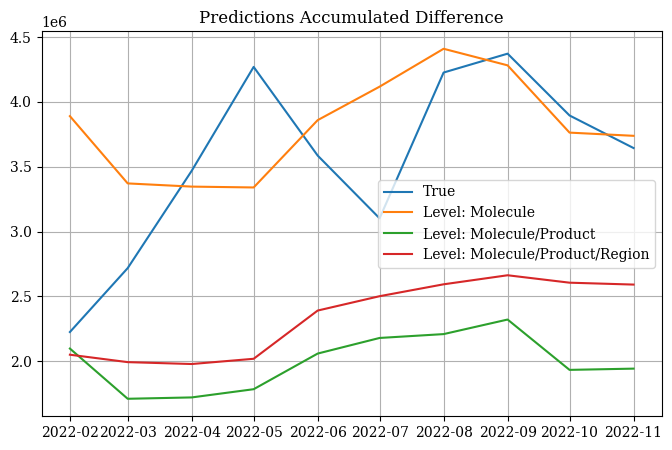

In [40]:
hplt = HierarchicalPlot(S=S_df, tags=tags)

hplt.plot_hierarchical_predictions_gap(Y_df=merged_test_preds_df, models = 'ETS')#['ETS', 'Naive', 'ETS/BottomUp', 'Naive/BottomUp'])

In [ ]:
hplt.plot_hierarchically_linked_series(bottom_series='Северо-западный ФО_Bisoprolol-Teva FC tabs 5 mg #50', Y_df=Y_train_df)

In [ ]:
# pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')

In [ ]:
# Y_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
# Y_df = Y_df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
# Y_df.insert(0, 'Country', 'Australia')
# Y_df = Y_df[['Country', 'Region', 'State', 'Purpose', 'ds', 'y']]
# Y_df['ds'] = Y_df['ds'].str.replace(r'(\d+) (Q\d)', r'\1-\2', regex=True)
# Y_df['ds'] = pd.to_datetime(Y_df['ds'])
# Y_df.head()